# Importing shit

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import math
import random
import numpy as np
import matplotlib.pyplot as plt

# Environment Setup

In [108]:
class NSGridEnv(gym.Env):
    def __init__(self, grid_size=5, change_interval=50):
        super(NSGridEnv, self).__init__()
        self.grid_size = grid_size
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=grid_size - 1, shape=(2,), dtype=np.int32)
        self.state = None
        self.steps = 0
        self.change_interval = change_interval
        self.goal_position = self._rand_goal()

    def _rand_goal(self):
        while True:
            goal = np.array([
                random.randint(0, self.grid_size - 1),
                random.randint(0, self.grid_size - 1)
            ])
            if not np.array_equal(goal, np.array([self.grid_size // 2, self.grid_size // 2])):
                return goal

    def reset(self):
        self.state = np.array([self.grid_size // 2, self.grid_size // 2])
        self.steps = 0
        return self.state.copy()

    def step(self, action):
        self.steps += 1
        if self.steps % self.change_interval == 0:
            self.goal_position = self._rand_goal()
        if action == 0 and self.state[1] < self.grid_size - 1:
            self.state[1] += 1
        elif action == 1 and self.state[1] > 0:
            self.state[1] -= 1
        elif action == 2 and self.state[0] > 0:
            self.state[0] -= 1
        elif action == 3 and self.state[0] < self.grid_size - 1:
            self.state[0] += 1
        done = np.array_equal(self.state, self.goal_position)
        reward = 1 if done else -0.1
        return self.state.copy(), reward, done, {}

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), '_', dtype='<U1')
        grid[self.state[1], self.state[0]] = 'A'
        grid[self.goal_position[1], self.goal_position[0]] = 'G'
        print('\n'.join([' '.join(row) for row in grid[::-1]]))
        print()

#Agent Implementation
## Q-Network

In [109]:
class QNet(nn.Module):
    def __init__(self, state_size, action_size, mem_size):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(state_size + mem_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state, memory):
        x = torch.cat((state, memory), dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

## MANN

In [110]:
class MemMod:
    def __init__(self, key_size, val_size, mem_capacity=1000):
        self.mem_capacity = mem_capacity
        self.keys = torch.zeros((mem_capacity, key_size))
        self.values = torch.zeros((mem_capacity, val_size))
        self.write_idx = 0

    def wr(self, key, value):
        idx = self.write_idx % self.mem_capacity
        self.keys[idx] = key
        self.values[idx] = value
        self.write_idx += 1

    def rd(self, query_key):
        if self.write_idx == 0:
            return torch.zeros(self.values.shape[1])
        similarities = torch.nn.functional.cosine_similarity(query_key, self.keys[:self.write_idx], dim=1)
        idx = torch.argmax(similarities).item()
        return self.values[idx]

## Prioritized Replay Buffer

In [111]:
class PRBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha

    def add_exp(self, error, sample):
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(sample)
        else:
            self.buffer[self.pos] = sample
        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity

    def samp(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:len(self.buffer)]
        probs = prios ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)
        return samples, indices, weights

    def upd_prio(self, indices, errors):
        self.priorities[indices] = np.abs(errors) + 1e-5

## Agent Class

In [112]:
class AgentDPERMem:
    def __init__(self, state_size, action_size, mem_size=2, buffer_capacity=1000):
        self.state_size = state_size
        self.action_size = action_size
        self.mem_size = mem_size
        self.mem_mod = MemMod(key_size=state_size, val_size=mem_size)
        self.q_net = QNet(state_size, action_size, mem_size)
        self.target_net = QNet(state_size, action_size, mem_size)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=0.001)
        self.buffer_capacity = buffer_capacity
        self.buffer = PRBuffer(capacity=buffer_capacity)
        self.steps_done = 0
        self.epsilon = 1.0
        self.eps_min = 0.1
        self.eps_decay = 0.995
        self.gamma = 0.99
        self.batch_size = 32
        self.update_target_every = 100
        self.beta = 0.4
        self.beta_inc = 0.001
        self.alpha = 0.6

    def sel_act(self, state, memory):
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            with torch.no_grad():
                q_values = self.q_net(state, memory)
                return torch.argmax(q_values).item()

    def mem_exp(self, error, experience):
        self.buffer.add_exp(error, experience)

    def repl(self):
        if len(self.buffer.buffer) < self.batch_size:
            return None
        self.beta = min(1.0, self.beta + self.beta_inc)
        samples, indices, weights = self.buffer.samp(self.batch_size, self.beta)
        batch = list(zip(*samples))
        states = torch.FloatTensor(np.vstack(batch[0]))
        actions = torch.LongTensor(batch[1]).unsqueeze(1)
        rewards = torch.FloatTensor(batch[2]).unsqueeze(1)
        next_states = torch.FloatTensor(np.vstack(batch[3]))
        dones = torch.FloatTensor(batch[4]).unsqueeze(1)
        memory = torch.zeros((self.batch_size, self.mem_size))
        for i in range(self.batch_size):
            key = states[i]
            memory[i] = self.mem_mod.rd(key)
        q_values = self.q_net(states, memory).gather(1, actions)
        with torch.no_grad():
            next_memory = torch.zeros((self.batch_size, self.mem_size))
            for i in range(self.batch_size):
                key = next_states[i]
                next_memory[i] = self.mem_mod.rd(key)
            next_q_values = self.target_net(next_states, next_memory).max(1)[0].unsqueeze(1)
            expected_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        td_errors = expected_q_values - q_values
        weights_tensor = torch.FloatTensor(weights).unsqueeze(1)
        loss = (weights_tensor * td_errors.pow(2)).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        errors = td_errors.detach().squeeze().numpy()
        self.buffer.upd_prio(indices, errors)
        if self.steps_done % self.update_target_every == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
        return loss.item()

    def upd_mem(self, state, action, reward, next_state):
        key = torch.FloatTensor(state)
        value = torch.FloatTensor(next_state - state)
        self.mem_mod.wr(key, value)

# Training shit

In [113]:
env = NSGridEnv()
agent = AgentDPERMem(state_size=2, action_size=4, mem_size=2, buffer_capacity=1000)
rewards_history = []
losses = []
epsilon_values = []
num_episodes = 500

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    cumulative_loss = 0
    loss_count = 0
    done = False
    while not done:
        agent.steps_done += 1
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        memory = agent.mem_mod.rd(state_tensor[0]).unsqueeze(0)
        action = agent.sel_act(state_tensor, memory)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        next_memory = agent.mem_mod.rd(next_state_tensor[0]).unsqueeze(0)
        with torch.no_grad():
            q_next = agent.target_net(next_state_tensor, next_memory).max(1)[0].item()
            q_target = reward + agent.gamma * q_next * (1 - int(done))
        q_current = agent.q_net(state_tensor, memory)[0][action].item()
        error = q_target - q_current
        agent.mem_exp(error, (state, action, reward, next_state, done))
        agent.upd_mem(state, action, reward, next_state)
        loss = agent.repl()
        if loss is not None:
            cumulative_loss += loss
            loss_count += 1
        state = next_state
    rewards_history.append(total_reward)
    epsilon_values.append(agent.epsilon)
    if loss_count > 0:
        average_loss = cumulative_loss / loss_count
    else:
        average_loss = 0
    losses.append(average_loss)
    if (episode + 1) % 50 == 0:
        print(f'Episode {episode+1}/{num_episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.4f}')
print("Training completed.")

Episode 50/500, Total Reward: 0.90, Epsilon: 0.1474
Episode 100/500, Total Reward: 0.50, Epsilon: 0.1000
Episode 150/500, Total Reward: 0.90, Epsilon: 0.1000
Episode 200/500, Total Reward: 0.90, Epsilon: 0.1000
Episode 250/500, Total Reward: 0.90, Epsilon: 0.1000
Episode 300/500, Total Reward: 0.90, Epsilon: 0.1000
Episode 350/500, Total Reward: 0.90, Epsilon: 0.1000
Episode 400/500, Total Reward: 0.70, Epsilon: 0.1000
Episode 450/500, Total Reward: 0.90, Epsilon: 0.1000
Episode 500/500, Total Reward: 0.50, Epsilon: 0.1000
Training completed.


# Plotting Performance

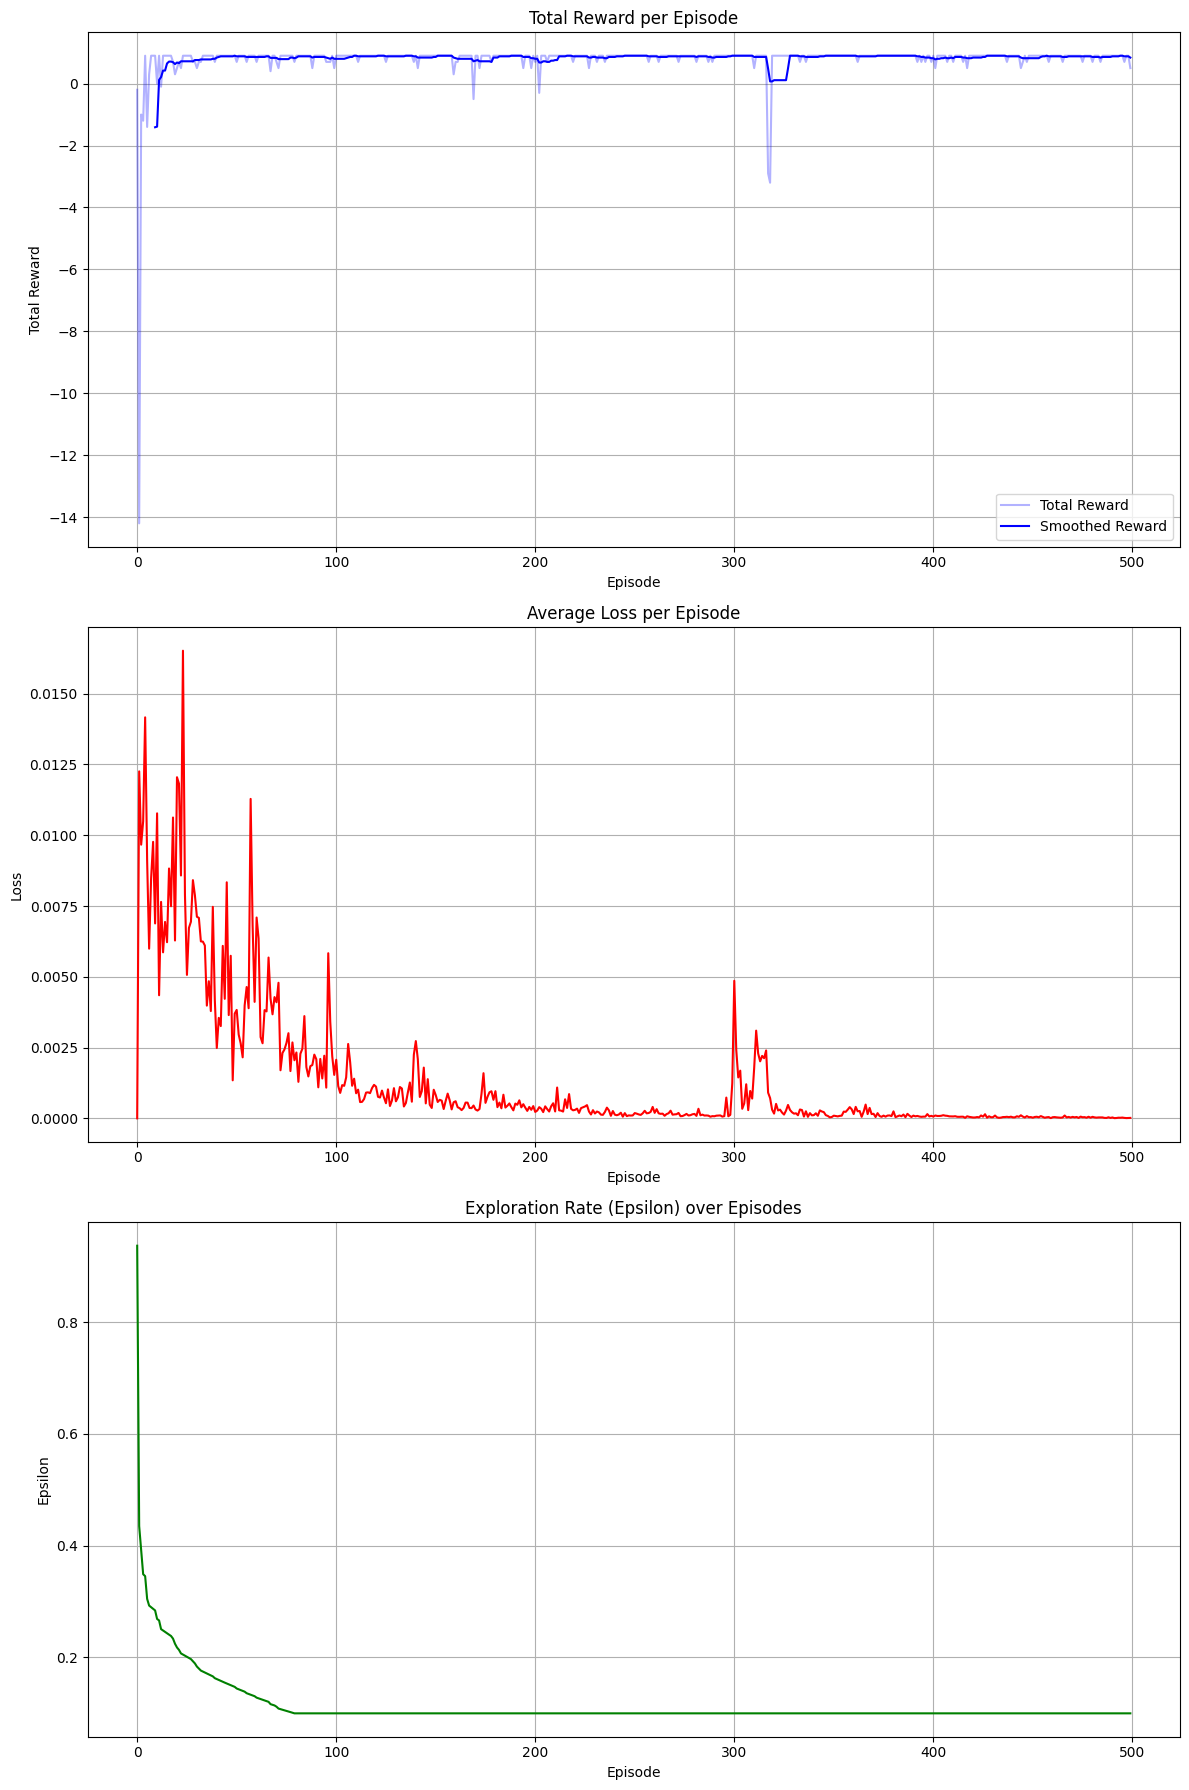

In [114]:
def moving_avg(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 10
rewards_smoothed = moving_avg(rewards_history, window_size)
episodes = np.arange(len(rewards_smoothed))

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].plot(rewards_history, color='blue', alpha=0.3, label='Total Reward')
axs[0].plot(episodes + window_size - 1, rewards_smoothed, color='blue', label='Smoothed Reward')
axs[0].set_title('Total Reward per Episode')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Total Reward')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(losses, color='red')
axs[1].set_title('Average Loss per Episode')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Loss')
axs[1].grid(True)

axs[2].plot(epsilon_values, color='green')
axs[2].set_title('Exploration Rate (Epsilon) over Episodes')
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Epsilon')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Visualizing Policy

In [116]:
def viz_policy(agent, grid_size):
    policy_grid = np.empty((grid_size, grid_size), dtype='<U2')
    action_symbols = ['↑', '↓', '←', '→']
    for y in range(grid_size):
        for x in range(grid_size):
            state = torch.FloatTensor([x, y]).unsqueeze(0)
            memory = agent.mem_mod.rd(state[0]).unsqueeze(0)
            with torch.no_grad():
                q_values = agent.q_net(state, memory)
                action = torch.argmax(q_values).item()
            policy_grid[y, x] = action_symbols[action]
    print("Learned Policy:")
    for row in policy_grid[::-1]:
        print(' '.join(row))

viz_policy(agent, env.grid_size)

Learned Policy:
→ → ↑ ← ←
↑ ↑ ↑ ↑ ←
↑ ↑ ↑ ↑ ←
↑ ↑ ↑ ← ←
↑ ↑ ↑ ← ←
